In [1]:
!pip install -q mnist

In [2]:
!wget 'https://github.com/DLR-SC/Neural-Network-Tutorial/raw/master/data/nn_theta_check.npy'

--2019-06-06 12:52:42--  https://github.com/DLR-SC/Neural-Network-Tutorial/raw/master/data/nn_theta_check.npy
Resolving github.com (github.com)... 140.82.118.3
Connecting to github.com (github.com)|140.82.118.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/DLR-SC/Neural-Network-Tutorial/master/data/nn_theta_check.npy [following]
--2019-06-06 12:52:43--  https://raw.githubusercontent.com/DLR-SC/Neural-Network-Tutorial/master/data/nn_theta_check.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.112.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.112.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 159160 (155K) [application/octet-stream]
Saving to: ‘nn_theta_check.npy’

nn_theta_check.npy  100%[===================>] 155.43K   639KB/s    in 0.2s    

2019-06-06 12:52:44 (639 KB/s) - ‘nn_theta_check.npy’ saved [159160/159160]



In [3]:
!wget 'https://raw.githubusercontent.com/DLR-SC/Neural-Network-Tutorial/master/mytools.py'

--2019-06-06 12:52:44--  https://raw.githubusercontent.com/DLR-SC/Neural-Network-Tutorial/master/mytools.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.112.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.112.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1022 [text/plain]
Saving to: ‘mytools.py.1’

mytools.py.1        100%[===================>]    1022  --.-KB/s    in 0s      

2019-06-06 12:52:44 (56.3 MB/s) - ‘mytools.py.1’ saved [1022/1022]



# Neural Networks - Excercise#

Now let's up our game and try some "real machine learning". In the following exercise we will:
 1. Implement and check the loss function of the Neural Network
 2. Classify images from a test data set and compute the accuracy.
 3. Figure out, how test set accuracy and training set accuracy depend on the number of samples.
 4. Try to improve the accuracy by changing the number of neurons in the hidden layer or by changing the regularization.
 
## Aim and Tasks ##  
We want to use a neural network to classify the MNIST dataset. This dataset consists of hand-written digits between 0 and 9, stored in $28\times28$ pixel images. <br>
The MNIST dataset is often called the "Hello World" of machine learning. 

![alt text](https://github.com/DLR-SC/Neural-Network-Tutorial/raw/master/images/mnist.png)
<br>We want to implement a simple neural network (just like in the example before) with the following architecture: 
 - The network has one input layer, one output layer and one hidden layer inbetween
 - The number of inputs $n_1$ equals the number of pixels (i.e. 28x28 = 784).
 - The number of hidden neurons ${n_2}$ can be chosen arbirarily, but for now we choose 25
 - The neural network has $K = 10$ output neurons, each of them representing one label. 
![alt text](https://github.com/DLR-SC/Neural-Network-Tutorial/raw/master/images/neural-network.png)

### Loading the data ### 
First, we will load the data:

In [1]:
from __future__ import print_function
import mnist

imgs_train = mnist.train_images()
y_train = mnist.train_labels()
imgs_test = mnist.test_images()
y_test = mnist.test_labels()

print(imgs_train.shape)
print(imgs_test.shape)

(60000, 28, 28)
(10000, 28, 28)


The entire training data set consists of 60 000 images, and the testing data set of 10 000 images. <br>
Let's see what the data looks like. Here is the first 8 images of the MNIST data set of hand-written numbers:

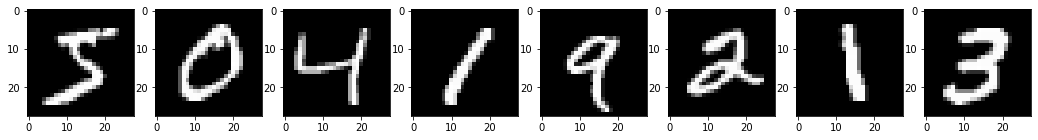

In [2]:
import matplotlib
import autograd.numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
fig, axes = plt.subplots(1, 8)
fig.set_size_inches(18, 8)

# show the first 8 images of the test set
for i in range(0, 8):
    ax = axes[i]
    ax.imshow(imgs_train[i, :, :], cmap='gray');

### Data normalization and preparation ###

As in the previous exercise, the data have to be normalized. Also, the 28 x 28 pixel 2D images are reshaped to a 1D input vectpor $X$ with 784 entries $x_i$

In [3]:
def normalize_and_prepare(imgs):
    # normalize between -0.5 ... 0.5
    imgs_norm = np.array(imgs, dtype=float) / 255. - 0.5
    # linearize the 2d image
    return imgs_norm.reshape((imgs.shape[0], imgs.shape[1] * imgs.shape[2]))

# we don't want to use the full data set, as our memory could run out
n_train = 10000
n_test = 10000

X_train = normalize_and_prepare(imgs_train[0:n_train, :, :])
X_test = normalize_and_prepare(imgs_test[0:n_test, :, :])

y_train = y_train[0:n_train]
y_test = y_test[0:n_test]

X_train.shape


(10000, 784)

## Implementation ##
Now it's your turn. Let's implement and train the network:

### Feed forward ###
__Excercise:__ First of all, implement the foward propagation, i.e. feed forward. For this, you will need the following steps:

 1) $ h^{(0)} = x $ (= X_train)  
 2) Add the row of 1s to $h^{(0)}$ to account for the constant bias  
 3) $ z^{(1)} = w^{(0)} h^{(0)} $  
 4) $ h^{(1)} = \sigma(z^{(1)})$  
 5) Add the row of 1s to $h^{(1)}$ to account for the constant bias  
 6) $ z^{(2)} = w^{(1)} h^{(1)} $  
 8) $ h^{(2)} = \sigma(z^{(2)})$  
 9) $y_{pred} = h^{(2)}$  
 

In [4]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def propagate(X, w_1, w_2):
    """
    Propagates the input X through the neural network
    :param theta_1: The parameters of hidden layer of the neural network
    :param theta_2: The parameters of output layer of the neural network
    :param X: The input data to be predicted
    :return:
    """
    # number of data items
    m_samples = X.shape[0]
    n_hidden_neurons = w_1.shape[1]
    n_output_neurons = w_2.shape[1]
    
    #### start your code ####

    # add the constant bias feature
    h_0 = np.hstack((np.ones((m_samples, 1)), X))
    
    z_1 = np.dot(h_0, w_1)
    h_1 = sigmoid(z_1)
    # add the constant bias feature
    h_1 = np.hstack((np.ones((m_samples, 1)), h_1))

    z_2 = np.dot(h_1, w_2)
    h_2 = sigmoid(z_2)
    o = h_2

    
    ###### end your code #####
    # assert o.shape == (m_samples, n_output_neurons)

    return o

Now compute the loss function $L$ from $y_{pred}$ and $y_{true}=$ y_train. <br>
We will use the loss function for logistic regression:
$$
L\left(\theta = (\pmb{W^{(0)}},\pmb{W^{(1)}}, \pmb{b^{(0)}}, \pmb{b^{(1)}})\right) = - \frac{1}{n} \sum_{i=1}^n y_i \:log\left(o_{\theta}(x_i)\right) + (1-y_i)\:log\left(1-o_{\theta}(x_i)\right) + \frac{\lambda}{2n}\sum_{j=1}^n\theta_j^2
$$


In [5]:
def extract_weights(w, neurons_per_layer):
    weight_layer = []
    start = 0
    for i in range(0, len(neurons_per_layer)-1):
        size = (neurons_per_layer[i] + 1) * neurons_per_layer[i+1]
        w_cur_layer = w[start: start+size].reshape((neurons_per_layer[i] + 1, neurons_per_layer[i+1]))
        weight_layer.append(w_cur_layer)
        start = start + size
    
    return weight_layer
    
import copy
def nn_loss_function(w, X, y, lam, n_hidden_neurons, n_labels):
    """
    :param theta: Parameters of the regressor
    :param X: Input values (n_samples x n_features)
    :param y: Ground truth labels for each sample of X
    :param lam: Regularization parameter
    :return: Cost value
    """

    # number of data items
    m_samples = X.shape[0]
    n_features = X.shape[1]
   
    w_1, w_2 = extract_weights(w, [n_features, n_hidden_neurons, n_labels])
    
    y_pred = propagate(X, w_1, w_2)
    
    #### start your code ####
    # TODO: Compute the loss function of the log regression
    cost = -y * np.log(y_pred) - (1. - y) * np.log(1. - y_pred)

    # regularized cost function
    L = 1. / m_samples * np.sum(cost) + lam / (2. * m_samples) * (np.sum(w_1[1:, :] ** 2) + np.sum(w_2[1:, :] ** 2))


    ###### end your code #####


    return L

### Accuracy check ###
Let's check the accuracy of the loss function. We load some pre-defined weights $w$ and compare the loss with a reference value.

In [6]:
import mytools
import numpy
# this loads already theta values for all labels.
# we want to check it however just for one label
w_check = numpy.load('nn_theta_check.npy')

expected_loss = nn_loss_function(w_check, X_train[0:5000],
                                 mytools.encode_one_hot(y_train[0:5000], 10),
                                                 0.1, 25, 10)

# this value must be roughly 6.730543
if np.abs(expected_loss - 6.730543) > 1e-4:
    print("Oooops... please check your loss function")
else:
    print("Hooray, your loss function looks good")

Hooray, your loss function looks good


### Training  ###

If your loss function passes the accuracy tests, it is time to do the training!

Do do symmetry breaking, we initialize the parameters $w$ with some small random numbers.

In [7]:
def initial_layer_weights(n_input, n_output):
    """
    Initialize theta randomly so that we break the symmetry while
                training the neural network.
    """

    eps = 0.12
    w = np.random.rand(n_input + 1, n_output) * eps * 2. - eps
    return w

This defines our training procedure...

In [8]:
import scipy.optimize
import autograd
def train(X, y, n_hidden_neurons, num_labels, regularization, max_iter):
    
    n_features = X.shape[1]

    # initialize parameters
    w_1 = initial_layer_weights(n_features, n_hidden_neurons)
    w_2 = initial_layer_weights(n_hidden_neurons, num_labels)

    # we have to linearize then for the optimizer
    w = np.hstack((w_1.flatten(), w_2.flatten()))

    def cost_function(t):
        return nn_loss_function(t, X, y, regularization, n_hidden_neurons, num_labels)

    print("Training neural network... time to get a coffee")

    res = scipy.optimize.minimize(cost_function,
                                  w, jac=autograd.grad(cost_function),
                                  options={'disp': True, 'maxiter': max_iter}, method='CG')

    # restore layer 1 and 2 parameters
    return extract_weights(res.x, [n_features, n_hidden_neurons, num_labels])

Now do the training!

In [9]:
n_hidden_neurons = 25
regularization = 2.25
n_train_samples = 3000
max_iter = 1000

w_1, w_2 = train(X_train[0: n_train_samples, :],
                         mytools.encode_one_hot(y_train[0: n_train_samples], 10),
                         n_hidden_neurons, 10, regularization, max_iter)

Training neural network... time to get a coffee


/home/debusc/pytorch_env/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]


         Current function value: 0.486321
         Iterations: 1000
         Function evaluations: 1392
         Gradient evaluations: 1392


### Classification  ###

First we implement our predictor.

In [10]:
def predict_label(X, w_1, w_2):
    """
    Predicts the data using the logistic regression approach
    :param X: The input data to be predicted
    :param theta_1: The parameters of hidden layer of the neural network
    :param theta_w: The parameters of output layer of the neural network
    :return:
    """
    h = propagate(X, w_1, w_2)

    # return index of maximum probability and probability
    return np.argmax(h, axis=1), np.max(h, axis=1)

Lets predict the first 8 images of the test set


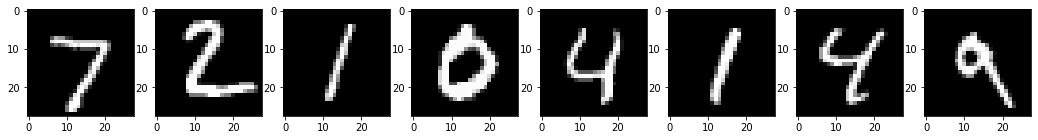

In [11]:
fig, axes = plt.subplots(1, 8)
fig.set_size_inches(18, 8)

# show the first 8 images of the test set
for i in range(0, 8):
    ax = axes[i]
    ax.imshow(imgs_test[i, :, :], cmap='gray');

In [12]:
prediction, probabilty = predict_label(X_test[0:8, :], w_1, w_2)
print ("Prediction: ", prediction)

Prediction:  [7 2 1 0 4 1 4 9]


Lets have a look at the probabilities:

In [13]:
print ("Probability: ", probabilty)

Probability:  [0.99606099 0.74325548 0.9711555  0.99364243 0.96650347 0.98751276
 0.9572768  0.7411938 ]


### Accuracy ###

Now, lets compute the accuracy of the classifier for the whole test set. A completely untrained classifier should roughly score 10%.

In [14]:
labels_predicted, probability = predict_label(X_test, w_1, w_2)
accuracy = np.mean(np.array(labels_predicted == y_test, dtype=float))
print ("Accuracy of the neural network on the test set: %g%%" % (accuracy*100.))

Accuracy of the neural network on the test set: 91.58%


## Further tasks## 
__Excercise:__
 - Investigate, how test accuracy and training accuracy depend on the test set size. Train the classifier with different n_train_samples and compute accuracies. What do you see?
 - Play around with the number of hidden layer neurons. What effect does it have?